In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

from scipy.stats import norm

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats, _get_gauss_stats

In [2]:
dataset = np.load(PWD + f'/data/dataset.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

# Utils

In [4]:
def plot_samples(X, y, y_pred, indices=[10, 11, 12, 13, 500, 1000, 2000, 3000]):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(X[idx])
        plt.axvline(y[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        diff = abs(y[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
        
def plot_difference_hist(y_true, y_pred, channel, method, hist_range=(-2, 2), n_bins=100):
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'{method}. channel={channel}, mean={mu:0.3f}, std={std:0.3f}')
    return std
    
def train_model(model, X_train, y_train, X_test, y_test, lr=0.001, name='model', train=True, 
                n_epochs=1000, verbose=1, batch_size=2048, lr_patience=None, es_patience=None, 
                loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/nn_channels_experiments/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/nn_channels_experiments/{name}/loss_log.csv')

    model.load_weights(f'model_weights/nn_channels_experiments/{name}/weights')
    history = pd.read_csv(f'model_weights/nn_channels_experiments/{name}/loss_log.csv')
    
    return history

In [5]:
def augmentation_random_cut(X, y, n_edge_cut=8, seed=None, apply=True):
    if not apply:
        return X[:, n_edge_cut:-n_edge_cut], y - n_edge_cut
    random_state = np.random.RandomState(seed)
    n_to_cut = n_edge_cut * 2
    
    start = random_state.randint(low=0, high=n_to_cut, size=X.shape[0])
    end = X.shape[1] - n_to_cut + start
    
    X_new = np.empty(shape=(X.shape[0], X.shape[1] - n_to_cut))
    for i in range(X.shape[0]):
        X_new[i] = X[i, start[i]:end[i]]
        
    y_new = y - start
    return X_new, y_new

In [6]:
def pred_and_retrieve_y(model, X):
    Y_heatmap = model.predict(X, batch_size=8192)
    y_pred = np.empty(len(X))
    for i, y in enumerate(Y_heatmap):
        try:
            y_pred[i] = _get_gauss_stats(y)
        except:
            # print(f'Error calculating {i}')
            y_pred[i] = np.average(np.arange(len(y)), weights=y)
    return y_pred

def compare_model_with_cfd(model, cfd, X, y_true, channel=None, figsize=(12, 4), show=True):
    y_cfd = np.array([cfd.predict(x) for x in X])
    y_model = pred_and_retrieve_y(model, X)
    
    mask = y_cfd != None
    y_cfd = y_cfd[mask]
    y_model = y_model[mask]
    
    print('=========================================================================')
    print(f'Channel {channel}')
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    std_cfd = plot_difference_hist(y_true, y_cfd, channel, 'CFD', hist_range=(-3, 3), n_bins=100)
    plt.subplot(1, 2, 2)
    std_model = plot_difference_hist(y_true, y_model, channel, 'NN', hist_range=(-3, 3), n_bins=100)
    
    improvement = (std_cfd - std_model) / std_cfd
    print(f"CFD: {std_cfd:0.3f}, NN: {std_model:0.3f} ({std_cfd * TIME_STEP:0.3f} ns vs {std_model * TIME_STEP:0.3f} ns)")
    print(f'Improvement: {improvement * 100:0.2f} %')
    if show:
        plt.show()
    else:
        plt.close()
    
cfd = CFD(n_baseline=10, fraction=0.25)

# Model

In [7]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

_get_gauss_stats(gaussian_kernel(np.array(1.6)))

1.6

In [8]:
def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # skip = residual_block(x, n_filters, strides=1)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # x = residual_block(x, n_filters, strides=1)
    return x
    
    
###################################

def create_model(filters_mult=1):
    inputs = layers.Input(48)
    x = layers.Reshape((-1, 1))(inputs)

    skip1, x = conv_block(x, 8 * filters_mult)
    skip2, x = conv_block(x, 16 * filters_mult)
    skip3, x = conv_block(x, 32 * filters_mult)
    x, _ = conv_block(x, 64 * filters_mult)

    x = deconv_block(x, skip3, 32 * filters_mult)
    x = deconv_block(x, skip2, 16 * filters_mult)
    x = deconv_block(x, skip1, 8 * filters_mult)

    x = layers.Conv1D(1, 1, activation='linear')(x)

    outputs = layers.Flatten()(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# All channels separately

In [9]:
for channel, (X, y) in list(all_channels_data.items()):
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])
    
    model = create_model(filters_mult=4)
    history = train_model(model, X_train, Y_heatmap_train, X_test, Y_heatmap_test, lr=0.001, name=f'model_separate_{channel}', 
                          train=False, n_epochs=200, verbose=0, loss_weights=100, lr_patience=20, es_patience=40)
    
    # plot_history(history, f"Channel {channel}, {len(X)} events", ymax=1, figsize=(10, 4))
    compare_model_with_cfd(model, cfd, X_test, y_test, channel, show=False)

Channel 8
CFD: 0.454, NN: 0.360 (0.071 ns vs 0.056 ns)
Improvement: 20.59 %
Channel 9
CFD: 0.459, NN: 0.400 (0.072 ns vs 0.063 ns)
Improvement: 12.83 %
Channel 10
CFD: 0.407, NN: 0.361 (0.064 ns vs 0.056 ns)
Improvement: 11.16 %
Channel 11
CFD: 0.423, NN: 0.358 (0.066 ns vs 0.056 ns)
Improvement: 15.29 %
Channel 13
CFD: 0.793, NN: 0.639 (0.124 ns vs 0.100 ns)
Improvement: 19.46 %
Channel 14
CFD: 0.716, NN: 0.604 (0.112 ns vs 0.094 ns)
Improvement: 15.60 %
Channel 16
CFD: 0.441, NN: 0.338 (0.069 ns vs 0.053 ns)
Improvement: 23.30 %
Channel 17
CFD: 0.458, NN: 0.372 (0.072 ns vs 0.058 ns)
Improvement: 18.86 %
Channel 18
CFD: 0.442, NN: 0.386 (0.069 ns vs 0.060 ns)
Improvement: 12.74 %
Channel 19
CFD: 0.561, NN: 0.482 (0.088 ns vs 0.075 ns)
Improvement: 14.02 %
Channel 20
CFD: 0.430, NN: 0.379 (0.067 ns vs 0.059 ns)
Improvement: 12.08 %
Channel 21
CFD: 0.427, NN: 0.389 (0.067 ns vs 0.061 ns)
Improvement: 8.83 %
Channel 22
CFD: 0.411, NN: 0.366 (0.064 ns vs 0.057 ns)
Improvement: 11.02 %
Ch

# Trained on one channel, tested on all

In [10]:
X_all = np.vstack([data[0] for data in all_channels_data.values()])
y_all = np.hstack([data[1] for data in all_channels_data.values()])

X_all_aug, y_all_aug = augmentation_random_cut(X_all, y_all, 8, seed=42, apply=True)

Y_all_heatmap = np.array([gaussian_kernel(y) for y in y_all_aug])

In [11]:
best_channel = 17

model = create_model(filters_mult=4)
model.load_weights(f'model_weights/nn_channels_experiments/model_separate_{channel}/weights')
model.compile(loss='mse', optimizer=optimizers.Adam(), loss_weights=100)

In [12]:
model.evaluate(X_all_aug, Y_all_heatmap, batch_size=8192)
# compare_model_with_cfd(model, cfd, X_all_aug, y_all_aug, 'all', show=False)

64/64 [==============================] - 5s 82ms/step - loss: 3.6443


3.644277572631836

# Trained on all the channels, tested on separate channels

In [13]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all_aug, y_all_aug, test_size=0.2, random_state=42)

Y_all_heatmap_train = np.array([gaussian_kernel(y) for y in y_all_train])
Y_all_heatmap_test = np.array([gaussian_kernel(y) for y in y_all_test])

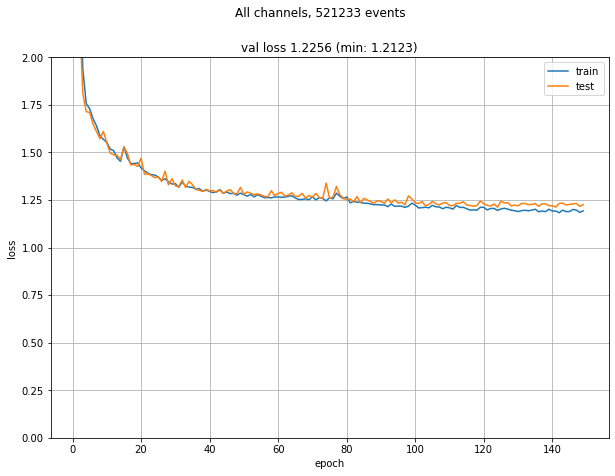

In [14]:
model = create_model(filters_mult=4)

history = train_model(model, X_all_train, Y_all_heatmap_train, X_all_test, Y_all_heatmap_test, lr=0.01, name=f'model_all_channels', 
                      batch_size=16384, train=False, n_epochs=250, verbose=1, loss_weights=100, lr_patience=10, es_patience=25)

plot_history(history, f"All channels, {len(X_all)} events", ymax=2, figsize=(10, 7))

channel:  8
Channel 8
CFD: 0.453, NN: 0.768 (0.071 ns vs 0.120 ns)
Improvement: -69.56 %
channel:  9
Channel 9
CFD: 0.460, NN: 0.692 (0.072 ns vs 0.108 ns)
Improvement: -50.44 %
channel:  10
Channel 10
CFD: 0.412, NN: 0.529 (0.064 ns vs 0.083 ns)
Improvement: -28.63 %
channel:  11
Channel 11
CFD: 0.413, NN: 0.707 (0.065 ns vs 0.111 ns)
Improvement: -71.26 %
channel:  13
Channel 13


ValueError: operands could not be broadcast together with shapes (40037,) (40038,) 

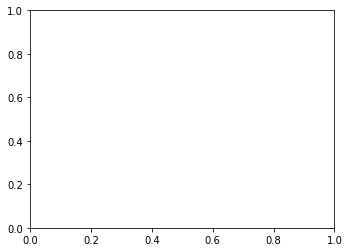

In [15]:
for channel, (X, y) in all_channels_data.items():
    X_aug, y_aug = augmentation_random_cut(X, y, 8, seed=42, apply=True)
    Y_heatmap = np.array([gaussian_kernel(y) for y in y_aug])
    
    print("channel: ", channel)
    # model.evaluate(X_aug, Y_heatmap, batch_size=8192)
    compare_model_with_cfd(model, cfd, X_aug, y_aug, channel, show=False)